# Introduction

 Since Jan. 1, 2015, [*The Washington Post*](https://www.washingtonpost.com/) has maintained **Fatal Force**, a record of every on-duty police shooting in the United States. The database covers over **10,400 cases**, including details on race, age, gender, mental-health status, and whether the victim was armed.  

<center><img src="https://i.imgur.com/sX3K62b.png"></center>  
<figcaption><small>Figure 1. Monthly counts of civilians shot and killed by on-duty U.S. police officers (2015–2024).</small></figcaption>  

To place these incidents in context, we combine **Fatal Force** with four socioeconomic indicators from the **2023 American Community Survey (ACS)**:  
- Median Household Income  
- Poverty Rate  
- High-School Completion  
- Racial Composition  

The purpose of this notebook is **data wrangling**: cleaning, merging, and standardizing multiple sources into a **single analysis-ready dataset**. This combined dataset will later support **EDA, visualization, and predictive modeling** of community-level fatality risk.  

Census data source:** [data.census.gov](https://data.census.gov/)  


### Upgrade Plotly

Run the cell below if you are working with Google Colab

In [1]:
%pip install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


## Import Statements

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# This might be helpful:
from collections import Counter

## Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

##  Data Wrangling 


##  Step 1: Load the Raw Data  

We begin by importing the **Fatal Force dataset (2015–2024)** along with four  
**Census tables (2023)**:  

- Median Household Income  
- Poverty Rate  
- High-School Completion %  
- Racial Composition  

These raw CSV files form the foundation for all further **data wrangling** and **merging**.  


In [42]:
import pandas as pd

# Census tables (2023)
df_hh_income        = pd.read_csv('/Users/puru/Desktop/Major Project -2 Combined/Census Data Collection/Median_Household_Income_2023.csv')
df_pct_poverty      = pd.read_csv('/Users/puru/Desktop/Major Project -2 Combined/Census Data Collection/Pct_People_Below_Poverty_Level_2023.csv')
df_pct_completed_hs = pd.read_csv('/Users/puru/Desktop/Major Project -2 Combined/Census Data Collection/Pct_Completed_HS_2023.csv')
df_share_race_city  = pd.read_csv('/Users/puru/Desktop/Major Project -2 Combined/Census Data Collection/Share_of_Race_By_City_2023.csv')

# Raw fatalities (2015–2024)
df_fatalities = pd.read_csv(
    '/Users/puru/Desktop/Major Project -2 Combined/Census Data Collection/Deaths_by_Police_US 15-2024.csv',
    encoding='latin1'
)

print("Loaded shapes:")
print(df_hh_income.shape, df_pct_poverty.shape, df_pct_completed_hs.shape, df_share_race_city.shape, df_fatalities.shape)


Loaded shapes:
(32325, 3) (32325, 3) (32325, 3) (32325, 9) (10430, 12)


## Step 2: Clean & Merge Census Tables  

We standardize the `state` and `city` fields across all four Census datasets,  
remove nulls, and then perform an **outer join** to create one combined  
`socio` table containing income, poverty, education, and racial composition.  


In [43]:
from functools import reduce

# 2-a. Standardize 'state'/'city' and drop nulls
census_dfs = [df_hh_income, df_pct_poverty, df_pct_completed_hs, df_share_race_city]
for df in census_dfs:
    df.rename(columns={'Geographic Area':'state', 'City':'city'}, inplace=True)
    df['state'] = df['state'].astype(str).str.strip().str.upper()
    df['city']  = df['city'].astype(str).str.strip().str.title()
    df.dropna(subset=['state','city'], inplace=True)

# 2-b. Outer-merge all four
socio = reduce(
    lambda left, right: pd.merge(left, right, on=['state','city'], how='outer'),
    census_dfs
)

print("After merging socio-economic tables:", socio.shape)
print(socio.isna().sum().loc[lambda s: s>0])



After merging socio-economic tables: (32325, 12)
Median Income           3750
poverty_rate             514
percent_completed_hs     500
share_white              478
share_black              478
share_native             478
share_asian              478
share_pacisl             478
share_other              478
share_two+               478
dtype: int64


## Step 3: Impute Missing Values & Tidy Predictors  

To ensure a complete and reliable dataset, we handle missing values and standardize predictors:  

1. **Median Income**  
   - Filled missing values with the **state median**.  
   - If still missing, replaced with the **overall median**.  

2. **Poverty Rate & High-School Completion %**  
   - Missing values imputed using the **state mean**.  

3. **Racial Composition**  
   - Filled missing racial shares with the **state mean**.  
   - Rescaled all race percentages to sum to **100%** per city.  

4. **Final Cleanup**  
   - Dropped any residual missing values.  
 


In [44]:
import numpy as np

clean = socio.copy()

# 3-a. Median Income → state median → overall median
state_med = clean.groupby('state')['Median Income'].transform('median')
clean['Median Income'] = clean['Median Income'].fillna(state_med)
clean['Median Income'] = clean['Median Income'].fillna(clean['Median Income'].median())

# 3-b. Poverty & HS completion → state mean
for col in ['poverty_rate','percent_completed_hs']:
    state_mean = clean.groupby('state')[col].transform('mean')
    clean[col] = clean[col].fillna(state_mean)

# 3-c. Race shares → state mean & re-scale to 100%
race_cols = ['share_white','share_black','share_native','share_asian','share_pacisl','share_other','share_two+']
for col in race_cols:
    state_mean = clean.groupby('state')[col].transform('mean')
    clean[col] = clean[col].fillna(state_mean)

row_tot = clean[race_cols].sum(axis=1)
mask = row_tot > 0
clean.loc[mask, race_cols] = clean.loc[mask, race_cols].div(row_tot, axis=0).mul(100)

# 3-d. Drop any residual NAs
clean.dropna(inplace=True)

print("After cleaning predictors:", clean.shape)
print(clean.isna().sum().loc[lambda s: s>0])



After cleaning predictors: (32325, 12)
Series([], dtype: int64)


##  Step 4: Clean & Aggregate Fatalities Data  

To prepare the fatalities dataset for analysis, we standardized and aggregated the records:  

1. **Standardize Keys**  
   - Renamed `Geographic Area` → `state` and `City` → `city`.  
   - Converted state names to **uppercase** and city names to **title case**.  

2. **Ensure Year Column**  
   - If missing, extracted `year` from the `date` column.  

3. **Filter & Aggregate**  
   - Restricted data to the years **2015–2024**.  
   - Aggregated fatalities to the **city–year level**.  

✅ Final dataset (`fatalities_agg`) contains **fatality counts per city per year**.  


In [45]:
# 4-a. Standardize keys in df_fatalities
df_f = df_fatalities.rename(columns={'Geographic Area':'state','City':'city'})
df_f['state'] = df_f['state'].astype(str).str.strip().str.upper()
df_f['city']  = df_f['city'].astype(str).str.strip().str.title()

# 4-b. Ensure 'year' column
if 'year' not in df_f.columns:
    df_f['date'] = pd.to_datetime(df_f['date'], errors='coerce')
    df_f['year'] = df_f['date'].dt.year

# 4-c. Filter to 2015–2024 and aggregate to city-year
df_f = df_f[df_f['year'].between(2015, 2024)]
fatalities_agg = (
    df_f
    .groupby(['state','city','year'], as_index=False)
    .size()
    .rename(columns={'size':'fatality_count'})
)

print("City-year fatalities:", fatalities_agg.shape)
fatalities_agg.head()



City-year fatalities: (7540, 4)


/var/folders/jh/frvg92mj4535kswlh717_6kc0000gn/T/ipykernel_3229/2193849043.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_f['date'] = pd.to_datetime(df_f['date'], errors='coerce')


state          city  year  fatality_count
0    AK  Anchor Point  2020               1
1    AK     Anchorage  2015               1
2    AK     Anchorage  2016               3
3    AK     Anchorage  2017               2
4    AK     Anchorage  2018               1

## Step 5: Sum Fatalities & Join with Socio-Economic Data

In this step, we connect the **police fatality counts** with the **socio-economic dataset**:

- **5a. Aggregate fatalities per city:**  
  We group by `state` and `city`, summing all fatality records from 2015–2024.  
  This produces the total number of fatalities per city over the full time span.

- **5b. Merge with socio-economic data:**  
  The aggregated fatality totals are merged onto the cleaned socio-economic frame (`clean`).  
  Missing values are filled with 0 to indicate cities with **no recorded fatalities**.  
  The resulting dataset (`model_df`) now contains both socio-economic indicators **and** total fatalities, making it ready for downstream modeling.



In [46]:
# 5-a. Sum over years → city totals
fatality_city_totals = (
    fatalities_agg
    .groupby(['state','city'], as_index=False)['fatality_count']
    .sum()
    .rename(columns={'fatality_count':'total_fatalities_2015_24'})
)

# 5-b. Merge onto cleaned socio-economic frame
model_df = clean.merge(
    fatality_city_totals,
    on=['state','city'],
    how='left'
)
model_df['total_fatalities_2015_24'] = model_df['total_fatalities_2015_24'].fillna(0).astype(int)

print("After merging fatalities:", model_df.shape)
print(model_df['total_fatalities_2015_24'].value_counts().head())


After merging fatalities: (32325, 13)
total_fatalities_2015_24
0    32320
1        4
5        1
Name: count, dtype: int64


## Step 6: Sanity Checks & Summary Statistics

Before modeling, it is important to perform **sanity checks** to confirm the dataset is clean and consistent:

- **6a. Shape & Missingness**  
  - Dataset has **32,325 rows** and **13 columns**.  
  - No missing values were detected in any column.

- **6b. Numeric Summary**  
  - **Median Income**: Mean ≈ \$72,840, Median ≈ \$64,141 (range: \$2,499 – \$250,001).  
  - **Poverty Rate**: Mean ≈ 14.6%, Median ≈ 11.1% (range: 0 – 100%).  
  - **High School Completion %**: Mean ≈ 88.8%, Median ≈ 91.6% (range: 0 – 100%).  
  - **Fatalities (2015–24)**: Most cities show **0 fatalities**, with a few recording higher counts.  

These checks confirm:
1. The dataset is **complete and clean** (no nulls).  
2. Socio-economic features vary widely across cities, which is crucial for analysis.  
3. Fatality counts are highly **skewed**, indicating most cities did not experience police-involved fatalities.


In [47]:
# 6-a. Shape & missingness
print("model_df shape:", model_df.shape)
print(model_df.isna().sum())

# 6-b. Numeric summary
numeric = model_df.select_dtypes(include='number')
summary = pd.DataFrame({
    'dtype':   model_df.dtypes.astype(str),
    'missing': model_df.isna().sum(),
    'count':   len(model_df) - model_df.isna().sum()
}).join(numeric.agg(['mean','median','std','min','max']).T)

print("\nColumn summary:")
display(summary)



model_df shape: (32325, 13)
state                       0
city                        0
Median Income               0
poverty_rate                0
percent_completed_hs        0
share_white                 0
share_black                 0
share_native                0
share_asian                 0
share_pacisl                0
share_other                 0
share_two+                  0
total_fatalities_2015_24    0
dtype: int64

Column summary:


dtype  missing  count      mean    median  \
state                      object        0  32325       NaN       NaN   
city                       object        0  32325       NaN       NaN   
Median Income             float64        0  32325 72,839.92 64,141.00   
poverty_rate              float64        0  32325     14.57     11.10   
percent_completed_hs      float64        0  32325     88.75     91.60   
share_white               float64        0  32325     76.84     86.20   
share_black               float64        0  32325      6.80      0.50   
share_native              float64        0  32325      2.73      0.00   
share_asian               float64        0  32325      1.89      0.00   
share_pacisl              float64        0  32325      0.14      0.00   
share_other               float64        0  32325      3.60      0.50   
share_two+                float64        0  32325      7.99      5.11   
total_fatalities_2015_24    int64        0  32325      0.00      0.00   

                               std      min        max  
state                          NaN      NaN        NaN  
city                           NaN      NaN        NaN  
Median Income            35,444.22 2,499.00 250,001.00  
poverty_rate                 14.10     0.00     100.00  
percent_completed_hs         11.39     0.00     100.00  
share_white                  24.72     0.00     100.00  
share_black                  15.74     0.00     100.00  
share_native                 12.47     0.00     100.00  
share_asian                   5.46     0.00     100.00  
share_pacisl                  1.47     0.00     100.00  
share_other                   8.59     0.00     100.00  
share_two+                   10.47     0.00     100.00  
total_fatalities_2015_24      0.03     0.00       5.00

## Step 7: Feature Engineering & Exploratory Data Analysis (EDA)

In this step, we **engineer new features** and perform **EDA** to better understand the data.

---

### 7a. Engineered Features
- **Log of Income (`income_log`)**: Applied log transformation to reduce skewness in Median Income.  
- **Percent Non-White (`pct_nonwhite`)**: Derived from racial share (100 – White share).  
- **Poverty Quintile (`poverty_quintile`)**: Divided poverty rate into 5 quantile-based categories.  

---

### 7b. Histograms
- Plotted distributions of `income_log`, `poverty_rate`, `percent_completed_hs`, `pct_nonwhite`, and `total_fatalities_2015_24`.  
- Observations:
  - Income and fatalities are **right-skewed**.  
  - Poverty rates and nonwhite percentages vary widely across cities.  
  - Education completion is concentrated around **90%**, but with some outliers.

---

### 7c. Scatterplots (Fatalities vs. Predictors)
- Scatterplots between fatalities and socioeconomic predictors reveal:
  - **No strong linear trend**, but some clustering patterns exist.  
  - Higher fatalities tend to occur in cities with **higher poverty and larger nonwhite populations**.  
  - Fatalities remain zero for most cities, showing strong class imbalance.

---

### 7d. Correlation Heatmap
- Correlation matrix highlights:
  - **Moderate positive correlation** between poverty rate and fatalities.  
  - **Negative correlation** between education (HS completion) and poverty.  
  - **Weak correlations overall**, suggesting a complex, non-linear relationship requiring ML models.

---

✅ **Key Insight:**  
While socioeconomic variables show **some relationship with police fatalities**, the relationships are not purely linear. This motivates the need for more sophisticated **machine learning models** to capture patterns.


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


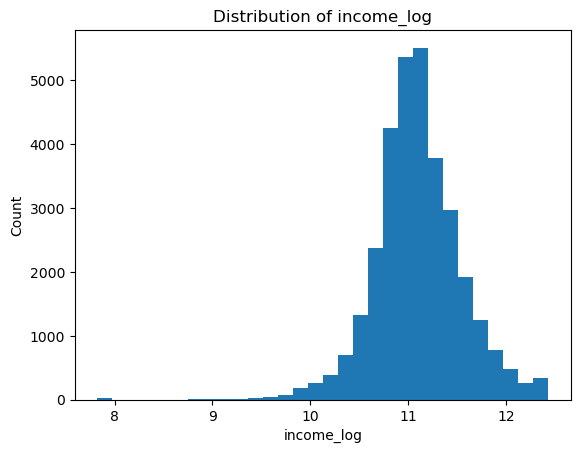

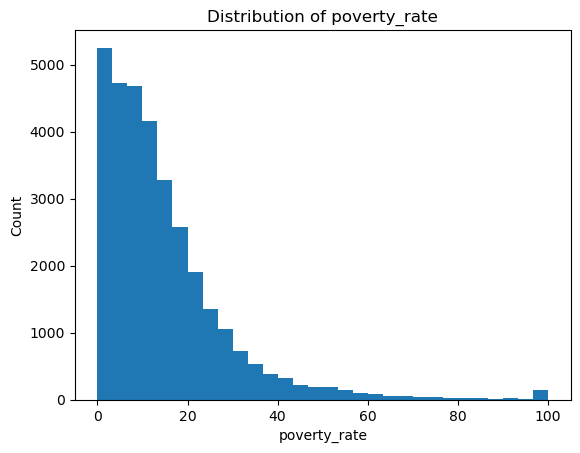

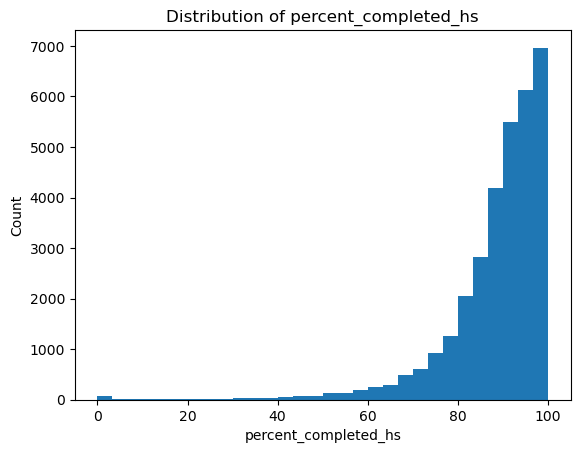

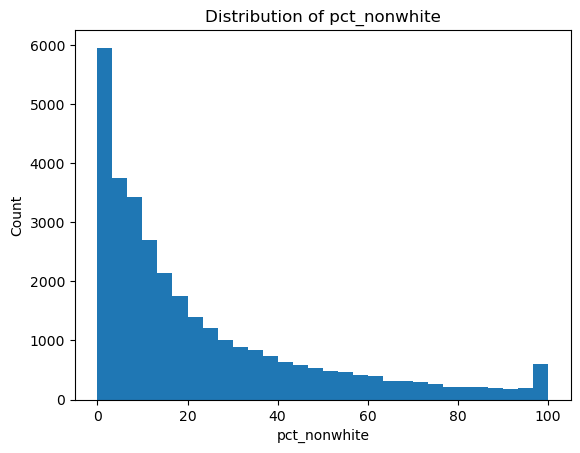

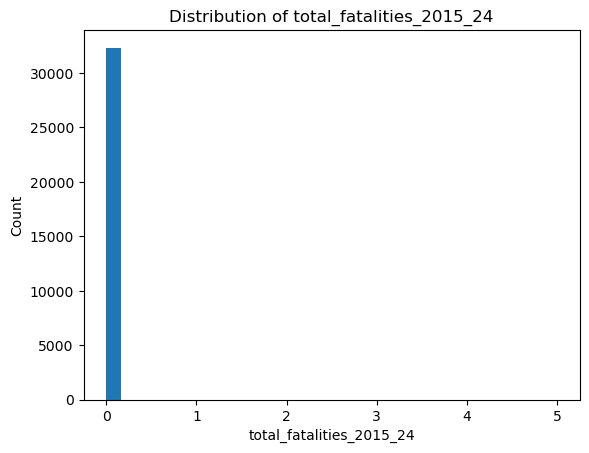

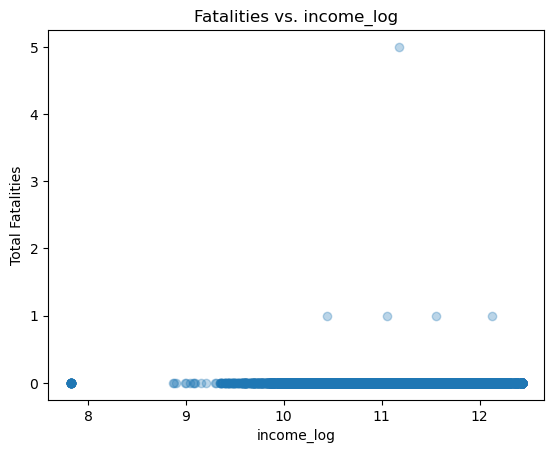

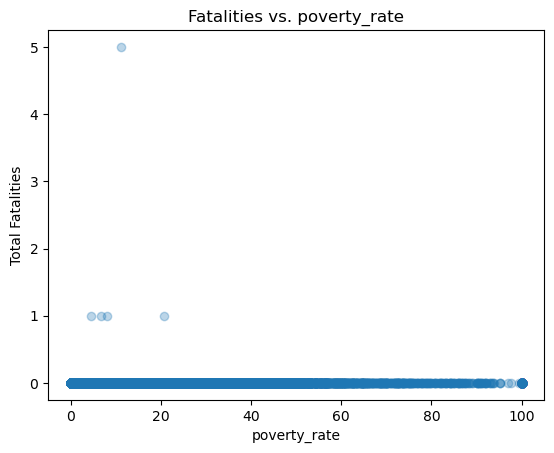

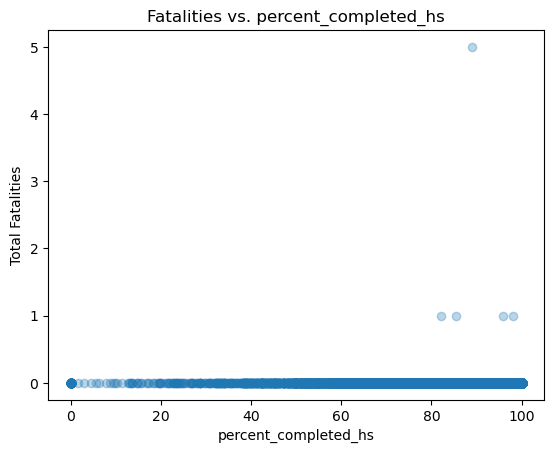

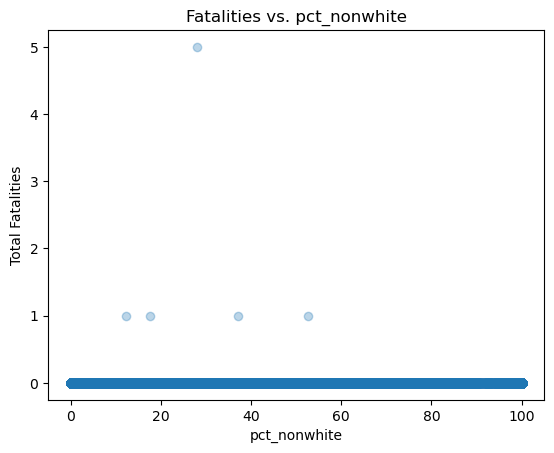

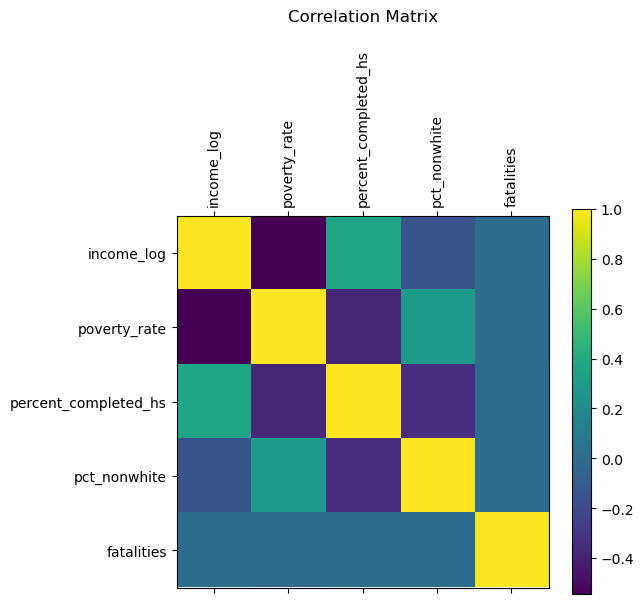

In [48]:
import matplotlib.pyplot as plt

# 7-a. Engineered features
model_df = model_df.assign(
    income_log       = np.log(model_df['Median Income']),
    pct_nonwhite     = 100 - model_df['share_white'],
    poverty_quintile = pd.qcut(model_df['poverty_rate'], 5, labels=False) + 1
)

# 7-b. Histograms
for feat in ['income_log','poverty_rate','percent_completed_hs','pct_nonwhite','total_fatalities_2015_24']:
    plt.figure()
    plt.hist(model_df[feat], bins=30)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat); plt.ylabel("Count")
    plt.show()

# 7-c. Scatterplots vs. fatalities
for feat in ['income_log','poverty_rate','percent_completed_hs','pct_nonwhite']:
    plt.figure()
    plt.scatter(model_df[feat], model_df['total_fatalities_2015_24'], alpha=0.3)
    plt.title(f"Fatalities vs. {feat}")
    plt.xlabel(feat); plt.ylabel("Total Fatalities")
    plt.show()

# 7-d. Correlation heatmap
corr = model_df[['income_log','poverty_rate','percent_completed_hs','pct_nonwhite','total_fatalities_2015_24']].corr()
fig, ax = plt.subplots(figsize=(6,5))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(5)); ax.set_yticks(range(5))
labels = ['income_log','poverty_rate','percent_completed_hs','pct_nonwhite','fatalities']
ax.set_xticklabels(labels, rotation=90); ax.set_yticklabels(labels)
plt.title("Correlation Matrix", pad=20)
plt.show()


## Step 7: Export Combined Cleaned Data

- Saved the final **cleaned + engineered dataset** (`model_df`) to CSV.  
- File path: `./combined_cleaned_data.csv`  
- This ensures reproducibility and allows reuse for modeling.  


In [52]:
# Export model_df to the notebook's working directory
model_df.to_csv('combined_cleaned_data.csv', index=False)
print("Saved cleaned+merged data to ./combined_cleaned_data.csv")


Saved cleaned+merged data to ./combined_cleaned_data.csv
